In [1]:
from argparse import Namespace
from pathlib import Path
from glob import glob
import json
import plotly.express as px
import plotly.graph_objects as go

scenes = []
for path in glob("../output/textured_train_test/*"):
    try:
        namespace = eval((Path(path) / "cfg_args").read_text())
        results = None
        if (Path(path) / "results.json").exists():
            results = json.loads((Path(path) / "results.json").read_text())
            scenes.append((namespace,results))
    except FileNotFoundError as e:
        print(e)

In [62]:
import pandas as pd

results_df = []
for namespace, results in scenes:
    print(namespace.source_path.split("/")[-1])
    if namespace.source_path.split("/")[-1] in ["ship","livingroom","mic","chair_background2",]:
        for name,res in results.items():
            name = name.replace("texture_per_gaussian","multitexture")
            scene_name = namespace.source_path.split("/")[-1]
            # print(name)
            ablation = ""
            if name[-6:] == "_score":
                ablation = "score"
                name = name[:-6]
            if name[-11:] == "_visibility":
                ablation = "visibility"
                name = name[:-11]
            if len(name.split("_"))==3:
                num_render_images = 100 if scene_name=="livingroom" else 50
            else:
                num_render_images = int(name.split("_")[-1])
                name = "_".join(name.split("_")[:-1])
            # print(name)
            
            train_run = namespace.model_path.split("/")[-1]
            loss_version = train_run.split("_")[-1]
            train_run = "_".join(train_run.split("_")[:-1])
            
            r = {
                "loss_version": loss_version,
                "scene_name": scene_name,
                "train_run": train_run,
                "train_mode": "depth" if "depth" in namespace.model_path else ("texture" if "texture" in namespace.model_path  else "normal"),
                "render_mode": ("texture_per_gaussian" if "per" in name else "texture") if "texture" in name else "normal",
                "method_name":"_".join(name.split("_")[:-1]),
                "iteration":int(name.split("_")[-1]),
                "num_render_images": num_render_images,
                "ablation":ablation,
                **res
            }
            if r["iteration"] in [1,100,200,300,400,500,600,700,800,900,1000,1500,2000, 3000, 4000, 5000, 7000, 10000, 13000, 16000, 20000, 25000, 30000, 35000, 40000, 47000, 55000, 70000]:
                results_df.append(r)


results_df = pd.DataFrame(results_df)

livingroom
chair_background2
ship
mic
mic
livingroom
chair_background2
livingroom
ship
livingroom
ship
ship
chair_background2
mic
chair_background2
chair_background2
mic
ship
livingroom
ship
livingroom
chair_background2
mic
mic


In [63]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df.sort_values(["scene_name","loss_version","iteration"]))

,loss_version,scene_name,train_run,train_mode,render_mode,method_name,iteration,num_render_images,ablation,SSIM,PSNR,LPIPS,num_gaussians
50,2,chair_background2,chair_background2_slow_textured,texture,texture,texture_scores2,1,50,,0.475997,22.219936,0.316427,55151
86,2,chair_background2,chair_background2_slow_textured_seed1,texture,texture,texture_scores2,1,50,,0.475997,22.219936,0.316427,55151
51,2,chair_background2,chair_background2_slow_textured,texture,texture,texture_scores2,500,50,,0.862320,28.240366,0.084607,55151
87,2,chair_background2,chair_background2_slow_textured_seed1,texture,texture,texture_scores2,500,50,,0.862810,28.269686,0.083958,55151
49,2,chair_background2,chair_background2_slow_textured,texture,texture,texture_scores2,1000,50,,0.854000,28.028908,0.098726,55151
85,2,chair_background2,chair_background2_slow_textured_seed1,texture,texture,texture_scores2,1000,50,,0.867489,28.272484,0.085378,55151
48,2,chair_background2,chair_background2_slow_textured,texture,texture,texture_scores2,1500,50,,0.826452,27.328964,0.132182,55151
84,2,chair_background2,chair_background2_slow_textured_seed1,texture,texture,texture_scores2,1500,50,,0.830768,27.465624,0.126246,55151
58,3,chair_background2,chair_background2_slow_textured_seed1,texture,texture,texture_scores2,1,50,,0.475997,22.219936,0.316427,55151
62,3,chair_background2,chair_background2_slow_textured,texture,texture,texture_scores2,1,50,,0.475997,22.219936,0.316427,55151


In [67]:
df = results_df.copy()
df["loss_version"] = df["loss_version"].where((df["iteration"]!=1),"0")
display(df["loss_version"].where(df["iteration"]!="1"))
df = df.groupby(["loss_version","scene_name","iteration"]).agg({'PSNR':['mean','std']}).droplevel(0,1).reset_index()
df = df.loc[df.groupby(["loss_version","scene_name"])["mean"].idxmax()]
#df = df.groupby(["loss_version","scene_name"]).max()
#df
df = df.set_index(["loss_version","scene_name"]).drop(columns="iteration")

form = df.apply(lambda r: f"{r['mean']:.2f}{{\\footnotesize ±{r['std']:.2f}}}",axis=1)

print(pd.concat([form["0"],form["2"],form["3"],form["6"]],axis=1,keys=["none","mask","photo","both"]).T.to_latex())

0     2
1     2
2     0
3     2
4     6
     ..
91    3
92    2
93    2
94    0
95    2
Name: loss_version, Length: 96, dtype: object

\begin{tabular}{lllll}
\toprule
scene_name & chair_background2 & livingroom & mic & ship \\
\midrule
none & 22.22{\footnotesize ±0.00} & 28.01{\footnotesize ±0.00} & 23.06{\footnotesize ±0.00} & 23.40{\footnotesize ±0.00} \\
mask & 28.26{\footnotesize ±0.02} & 28.50{\footnotesize ±0.03} & 28.26{\footnotesize ±0.00} & 24.72{\footnotesize ±0.04} \\
photo & 28.68{\footnotesize ±0.03} & 28.62{\footnotesize ±0.26} & 28.00{\footnotesize ±0.07} & 26.33{\footnotesize ±0.05} \\
both & 28.93{\footnotesize ±0.01} & 28.82{\footnotesize ±0.01} & 29.02{\footnotesize ±0.06} & 25.30{\footnotesize ±0.00} \\
\bottomrule
\end{tabular}



<Axes: xlabel='iteration'>

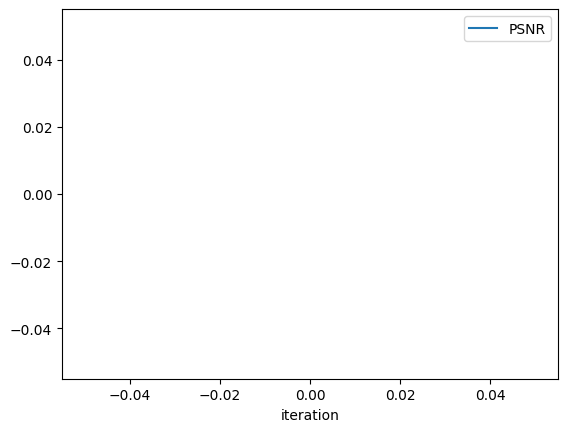

In [4]:
results_df[results_df["train_run"]=="chair_background2_slow_textured_26"].sort_values("iteration").plot("iteration","PSNR")

In [5]:
import numpy as np
data = [float(x.split(" ")[2]) for x in Path("../log").read_text().split("\n") if "Mean PSNR" in x]
one = np.array(data[::3]).reshape((4,3))
two = np.array(data[1::3]).reshape((4,3))
three = np.array(data[2::3]).reshape((4,3))
print((two-one).mean(axis=0))
print((three-two).mean(axis=0))

ValueError: cannot reshape array of size 16 into shape (4,3)

In [ ]:
import numpy as np
from pathlib import Path
data = [float(x.split(" ")[2]) for x in Path("../log_textured_train_full").read_text().split("\n") if "Mean PSNR" in x]
one = np.array(data[::2]).reshape((4,7))
two = np.array(data[1::2]).reshape((4,7))
a = (two-one)[:, :]
a

array([[ 4.10481955,  4.21183681,  4.47127754,  4.30188119,  4.06125109,
         3.11418302,  4.18574504],
       [ 5.7206576 ,  5.44139676,  5.43121057,  5.30573212,  5.54811453,
         3.60755223,  5.89680827],
       [ 2.11126548,  2.05799163,  0.82063073,  2.61225665,  2.73097169,
         1.45960371,  2.82235035],
       [-1.42771354,  0.99040725,  0.18997992,  1.10104809, -0.08648021,
         0.08177592,  0.02172692]])

In [ ]:
import numpy as np
data = [float(x.split(" ")[2]) for x in Path("../log_1_4_6").read_text().split("\n") if "Mean PSNR" in x]
one = np.array(data[::2]).reshape((4,6))
two = np.array(data[1::2]).reshape((4,6))
b = (one)[:4,:3]

In [ ]:
import numpy as np
from pathlib import Path
data = [float(x.split(" ")[2]) for x in Path("../log").read_text().split("\n") if "Mean PSNR" in x]
one = np.array(data[::2]).reshape((4,6))
two = np.array(data[1::2]).reshape((4,6))
b = (one)[:4,:3]

ValueError: cannot reshape array of size 40 into shape (4,6)

In [ ]:
train = np.array(data[::2])
test = np.array(data[1::2])

print(test.reshape((-1,4)))

[[23.07623517 28.13741473 28.36200117 27.97479353]
 [23.07623517 27.53716102 27.83744315 27.90640043]
 [23.07623517 27.288298   22.23646932 28.274916  ]
 [28.23935584 27.38416622 22.23646932 28.00771743]
 [28.5225814  28.69536987 22.23646932 28.08071031]
 [23.41966488 24.72743968 24.68046635 24.35360678]
 [23.41966488 26.14772872 26.30902822 26.37996433]
 [23.41966488 26.21841662 28.06466958 28.57298573]
 [28.13888681 27.63437146 28.06466958 29.33981616]
 [29.1715523  29.08560663 28.06466958 28.24833269]]


: 

In [ ]:
mean = (a+b)/2
std = np.abs(a-b)
out = ""
for i in range(3):
    #out += " & ".join(f"{m:.2f}{{\\footnotesize ±{s:.2f}}}" for m,s in zip(mean[:,i],std[:,i])) + "\\\\ \n"
    out += " & ".join(f"{m:.2f}" for m,s in zip(mean[:,i],std[:,i])) + "\\\\ \n"
print(out)

25.18 & 24.96 & 24.45 & 28.56\\ 
25.11 & 25.01 & 24.79 & 28.02\\ 
25.17 & 25.18 & 24.83 & 28.08\\ 



In [ ]:
a

array([[27.28807198, 27.13748626, 27.26198021],
       [27.67786608, 27.78458384, 28.13327759],
       [25.47765652, 26.15063657, 26.24201524],
       [29.05507683, 27.97818937, 28.08639649]])

In [ ]:
b

array([[27.26876289, 27.24644867, 27.288298  ],
       [27.68471121, 27.79132557, 28.08071031],
       [25.47725607, 26.19768901, 26.21841662],
       [29.06916156, 27.621449  , 28.24833269]])

In [1]:
import numpy as np
from pathlib import Path
data = [float(x.split(" ")[2]) for x in Path("../log").read_text().split("\n") if "Mean PSNR" in x]

In [2]:
train,test = data[::2], data[1::2]

In [4]:
scenes=4
loss_versions = 1
seeds=1
iterations=12

train = train + [0]*(scenes*loss_versions*seeds*iterations - len(train))
train = np.array(train).reshape((scenes,loss_versions,seeds,iterations))
test = test + [0]*(scenes*loss_versions*seeds*iterations - len(test))
test = np.array(test).reshape((scenes,loss_versions,seeds,iterations))


In [1]:
import matplotlib.pyplot as plt
x = [0,100,200,300,400,500,700,900,1000,1100,1300,1500]
plt.plot(x,train.mean(0).flatten(),label="Training set")
plt.plot(x,test.mean(0).flatten(),label="Testing set")
plt.xlabel("Iterations")
plt.ylabel("PSNR")
plt.legend()
plt.savefig("../figures/textured_training_iterations_plot.pdf")

NameError: name 'train' is not defined

In [1]:
import numpy as np
from pathlib import Path
data = [float(x.split(" ")[2]) for x in Path("../log").read_text().split("\n") if "Mean PSNR" in x]

In [6]:
import pandas as pd
df = pd.DataFrame(np.array(data).reshape((4,4)).T)

In [11]:
df = df.set_axis(['Chair', 'Microphone', 'Ship', 'Livingroom'], axis=1)
df = df.set_axis(['3DGS + Normalized Depth', '3DGS + Non-normalized Depth', 'Depth Supervision + Non-normalized Depth', 'Depth Supervision + Normalized Depth'], axis=0)
df.format("{:.2f}").to_latex()

,Chair,Microphone,Ship,Livingroom
3DGS + Normalized Depth,0.178857,0.136036,0.252028,0.165600
3DGS + Non-normalized Depth,6.311471,5.578582,1.309321,0.195666
Depth Supervision + Non-normalized Depth,0.072137,0.370150,0.045548,0.018093
Depth Supervision + Normalized Depth,0.033515,0.266926,0.033062,0.010874
